## CPSC 533V: Assignment 2 - Tabular Q Learning

<p style="font-size: 1.2em;">Due Date: Wed Oct 6, 2021</p>
<p style="font-size: 1.2em;">100 Points Total (9% of final grade)</p>

## Important Notes

* Your deliverable is this Jupyter Notebook. Submission will be done via Canvas.
* For instructions on installing and running Jupyter Notebook: https://jupyter.org/install
    * Start by cloning this repository: git clone git@github.com:UBCMOCCA/CPSC533V_2021W1.git
    * Install Jupyter Notebook using either `conda install jupyter` or `pip install jupyter`
    * Inside the `a2` folder, run `jupyter notebook` and a webpage should open in the browser
    * If not, follow the instruction in terminal to launch an interactive session
* If you use additional Python packages, please list them  as it will help with grading. 
* **We recommend working in groups of two**. List your names and student numbers below (if you use a different name on Canvas).

<ul style="list-style-type: none; font-size: 1.2em;">
<li>Name (and student ID):Haomiao Zhang 33074155</li>
<li>Name (and student ID):</li>
</ul>


## Debugging Tips

* Debugging in Jupyter Notebook can be using `pdb` or `ipdb`
* Insert `import ipdb; ipdb.set_trace()` to where you want to set a breakpoint
* See https://docs.python.org/3/library/pdb.html#debugger-commands for useful commands
* Remember to quit out from an `ipdb` session, otherwise you may wonder why a code cell is taking forever to complete 😉

---

##  Tabular Q-Learning

Tabular Q-learning is an RL algorithm for problems with discrete states and discrete actions. The algorithm is described in the class notes, which borrows the summary description from [Section 6.5](http://incompleteideas.net/book/RLbook2018.pdf#page=153) of Richard Sutton's RL book. In the tabular approach, the Q-value is represented as a lookup table. As discussed in class, Q-learning can further be extended to continuous states and discrete actions, leading to the [Atari DQN](https://arxiv.org/abs/1312.5602) / Deep Q-learning algorithm.  However, it is important and informative to first fully understand tabular Q-learning.

Informally, Q-learning works as follows: The goal is to learn the optimal Q-function: 
`Q(s,a)`, which is the *value* of being at state `s` and taking action `a`.  Q tells you how well you expect to do, on average, from here on out, given that you act optimally.  Once the Q function is learned, choosing an optimal action is as simple as looping over all possible actions and choosing the one with the highest Q (optimal action $a^* = \text{max}_a Q(s,a)$).  To learn Q, we initialize it arbitrarily and then iteratively refine it using the Bellman backup equation for Q functions, namely: 
$Q(s,a) \leftarrow Q(s,a) + \alpha [r + \gamma \text{max}_a Q(s', a) - Q(s,a)]$.
Here, $r$ is the reward associated with with the transition from state s to s', and $\alpha$ is a learning rate.

In this assignment you will implement tabular Q-learning and apply it to CartPole – an environment with a **continuous** state space.  To apply the tabular method, **you will need to discretize the CartPole state space** by dividing the state-space into bins.


**Assignment goals:**
- To become familiar with Python, NumPy, and OpenAI Gym
- To understand and implement tabular Q-learning
- To experiment tabular Q-learning on your implemention of discrete CartPole environment
- (Optional) To develop further intuition regarding possible variations of the algorithm

## Introduction
Deep reinforcement learning has generated impressive results for board games ([Go][go], [Chess/Shogi][chess]), video games ([Atari][atari], , [DOTA2][dota], [StarCraft II][scii]), [and][baoding] [robotic][rubix] [control][anymal] ([of][cassie] [course][mimic] 😉).  RL is beginning to work for an increasing range of tasks and capabilities.  At the same time, there are many [gaping holes][irpan] and [difficulties][amid] in applying these methods. Understanding deep RL is important if you wish to have a good grasp of the modern landscape of control methods.

These next several assignments are designed to get you started with deep reinforcement learning, to give you a more close and personal understanding of the methods, and to provide you with a good starting point from which you can branch out into topics of interest. You will implement basic versions of some of the important fundamental algorithms in this space, including Q-learning, policy gradient, and search methods.

We will only have time to cover a subset of methods and ideas in this space.
If you want to dig deeper, we suggest following the links given on the course webpage.  Additionally we draw special attention to the [Sutton book](http://incompleteideas.net/book/RLbook2018.pdf) for RL fundamentals and in depth coverage, and OpenAI's [Spinning Up resources](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html) for a concise intro to RL and deep RL concepts, as well as good comparisons and implementations of modern deep RL algorithms.


[atari]: https://arxiv.org/abs/1312.5602
[go]: https://deepmind.com/research/case-studies/alphago-the-story-so-far
[chess]:https://deepmind.com/blog/article/alphazero-shedding-new-light-grand-games-chess-shogi-and-go 
[dota]: https://openai.com/blog/openai-five/
[scii]: https://deepmind.com/blog/article/AlphaStar-Grandmaster-level-in-StarCraft-II-using-multi-agent-reinforcement-learning
[baoding]: https://bair.berkeley.edu/blog/2019/09/30/deep-dynamics/
[rubix]: https://openai.com/blog/solving-rubiks-cube/
[cassie]: https://www.cs.ubc.ca/~van/papers/2019-CORL-cassie/index.html
[mimic]: https://www.cs.ubc.ca/~van/papers/2018-TOG-deepMimic/index.html
[anymal]: https://arxiv.org/abs/1901.08652


[irpan]: https://www.alexirpan.com/2018/02/14/rl-hard.html
[amid]: http://amid.fish/reproducing-deep-rl



In [5]:
# Install dependencies
# Only run if necessary
!pip install gym
!pip install numpy
!pip install matplotlib

In [6]:
import time
import itertools
import numpy as np
import gym

---

## 1. Explore the CartPole environment [18 pts]

Your first task is to familiarize yourself with the OpenAI gym interface and the [CartPole environment]( https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py)
by writing a simple hand-coded policy to try to solve it.  
Read this brief introduction on [OpenAI Gym](https://gym.openai.com/docs/) to get started. 
The gym interface is very popular and you will see many algorithm implementations and 
custom environments that support it.  You may even want to use the API in your course projects, 
to define a custom environment for a task you want to solve.

Below is some example code that runs a simple random policy.  You are to:
- **run the code to see what it does**
- **write code that chooses an action based on the observation**.  You will need to learn about the gym API and to read the CartPole documentation to figure out what the `action` and `obs` vectors mean for this environment. 
Your hand-coded policy can be arbitrary, and it should ideally do better than the random policy.  There is no single correct answer. The goal is to become familiar with `env`s.
- **write code to print out the total reward gained by your policy in a single episode run**
- **answer the short-response questions below** (see the TODOs for all of this)

In [7]:
env = gym.make('CartPole-v1')  # you can also try LunarLander-v2, but make sure to change it back
print('observation space:', env.observation_space)
print('action space:', env.action_space)

# To find out what the observations mean, read the CartPole documentation.
# Uncomment the lines below, or visit the source file: 
# https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py

cartpole = env.unwrapped
cartpole?

observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
action space: Discrete(2)


Type:        CartPoleEnv
String form: <CartPoleEnv<CartPole-v1>>
File:        ~/anaconda3/envs/openaigym/lib/python3.8/site-packages/gym/envs/classic_control/cartpole.py
Docstring:  
Description:
    A pole is attached by an un-actuated joint to a cart, which moves along
    a frictionless track. The pendulum starts upright, and the goal is to
    prevent it from falling over by increasing and reducing the cart's
    velocity.

Source:
    This environment corresponds to the version of the cart-pole problem
    described by Barto, Sutton, and Anderson

Observation:
    Type: Box(4)
    Num     Observation               Min                     Max
    0       Cart Position             -4.8                    4.8
    1       Cart Velocity             -Inf                    Inf
    2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
    3       Pole Angular Velocity     -Inf                    Inf

Actions:
    Type: Discrete(2)
    Num   Action
    0     Push ca

In [8]:
#snippet
obs =env.reset()
print(obs)
print(obs[2])
print(env.action_space)
action = env.action_space.sample()
print(action)
obs?

[-0.04247563 -0.02855821 -0.04768119 -0.04330663]
-0.047681186
Discrete(2)
1


Type:            ndarray
String form:     [-0.04247563 -0.02855821 -0.04768119 -0.04330663]
Length:          4
File:            ~/anaconda3/envs/openaigym/lib/python3.8/site-packages/numpy/__init__.py
Docstring:       <no docstring>
Class docstring:
ndarray(shape, dtype=float, buffer=None, offset=0,
        strides=None, order=None)

An array object represents a multidimensional, homogeneous array
of fixed-size items.  An associated data-type object describes the
format of each element in the array (its byte-order, how many bytes it
occupies in memory, whether it is an integer, a floating point number,
or something else, etc.)

Arrays should be constructed using `array`, `zeros` or `empty` (refer
to the See Also section below).  The parameters given here refer to
a low-level method (`ndarray(...)`) for instantiating an array.

For more information, refer to the `numpy` module and examine the
methods and attributes of an array.

Parameters
----------
(for the __new__ method; see Notes b

**1.1 [10pts] Complete the `TODO`s in the next code block**

In [9]:
# Q1.1

# Runs a single episode and render it
# Try running this before editing anything

obs = env.reset()  # get initial state/observation
reward_sum =0

while True:
    # TODO: replace this `action` with something that depends on `obs` 
    
    #import ipdb; ipdb.set_trace()
    if obs[2]<=0:
        action = 0
    else:
        action = 1
    #action = env.action_space.sample()  # random action
    obs, reward, done, info = env.step(action)
    
    reward_sum+=reward
    
    env.render()
    time.sleep(0.1)  # so it doesn't render too quickly
    if done: break
env.close()

# TODO: print out your total sum of rewards here
print(reward_sum)

/home/haomiaoz/anaconda3/envs/openaigym/lib/python3.8/site-packages/pyglet/window/__init__.py:667: UserWarning: 
Your graphics drivers do not support OpenGL 2.0.
You may experience rendering issues or crashes.
Intel
Intel(R) UHD Graphics 620
1.4 (4.6.0 - Build 27.20.100.8337)
  warnings.warn(message)


52.0


**1.2. [2pts] Describe the observation and action spaces of CartPole.  What does each of the values mean/do?**

*Hint: Look at the full [source code here](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py) if you haven't already.*


The observation space has 4 dimensions, which represent the linear position and velocity of the cart and the angular position and velocity of the pole.

**1.3. [2pts] What distribution is used to sample initial states? (see the `reset` function)** 

A uniform distribution between -0.05 and 0.05 for each state variable.

**1.4. [2pts] What is the termination condition, which determines if the `env` is `done`?** 

There are multiple:
* Pole angle is larger than 12 degrees in either directions
* Cart reaches the edge, which is the position of cart is larger than 2.4 in either direction
* Episode length is longer than 200

**1.5. [2pts] Briefly describe your policy.  What observation information does it use?  What score did you achieve (rough maximum and average)?  And how does it compare to the random policy?**

When pole is falling to the left, push the cart to the left continously. If the pole is falling to the right, push the cart to the right continously. Only the angular position of the pole is used. The maximum reward during trail is 61, and the average is around 45. Random policy would achieve a reward of 20 on average, so the new policy is better than random policy.

---

## 2. Discretize the environment [32 pts]

Next, we need to discretize CartPole's continuous state space to work for tabular Q-learning.  While this is in part  a contrived usage of tabular methods, given the existence of other approaches that are designed to cope with continuous state-spaces, it is also interesting to consider whether tabular methods can be adapted more directly via discretization of the state into bins. Furthermore, tabular methods are simple, interpretabile, and can be proved to converge, and thus they still remain relevant.

Your task is to discretize the state/observation space so that it is compatible with tabular Q-learning.  To do this:
- **implement `obs_normalizer` to pass its test**
- **implement `get_bins` to pass its test**
- **then answer questions 2.3 and 2.4**

[map]: https://arxiv.org/abs/1504.04909
[qd]: https://quality-diversity.github.io/

**2.1 [15pts for passing test_normed]** Normalize observation space

In [10]:
# Q2.1

def obs_normalizer(obs):
    """Normalize the observations between 0 and 1
    
    If the observation has extremely large bounds, then clip to a reasonable range before normalizing; 
    (-2,2) should work.  (It is ok if the solution is specific to CartPole)
    
    Args:
        obs (np.ndarray): shape (4,) containing an observation from CartPole using the bound of the env
    Returns:
        normed (np.ndarray): shape (4,) where all elements are roughly uniformly mapped to the range [0, 1]
    
    """
    # HINT: check out env.observation_space.high, env.observation_space.low
    
    #Assume env.observation_space.high, env.observation_space.low are global
    #solution is specific to cartpole
    linear_v_low = -2
    linear_v_high = -linear_v_low
    angular_v_low  = -2
    angular_v_high = -angular_v_low

    low_bound = env.observation_space.low
    low_bound[1] = linear_v_low
    low_bound[3] = angular_v_low

    high_bound = env.observation_space.high
    high_bound[1] = linear_v_high
    high_bound[3] = angular_v_high

    normed = (obs-low_bound)/(high_bound-low_bound)
    return normed

    

In [11]:
### TEST 2.1
def test_normed():
    obs = env.reset()
    while True:
        obs, _, done, _ =  env.step(env.action_space.sample())
        normed = obs_normalizer(obs) 
        assert np.all(normed >= 0.0) and np.all(normed <= 1.0), '{} are outside of (0,1)'.format(normed)
        if done: break
    env.close()
    print('Passed!')
test_normed()

Passed!


**2.2 [13pts for passing test_binned]**

In [12]:
# Q2.2

def get_bins(normed, num_bins):
    """Map normalized observations (0,1) to bin index values (0,num_bins-1)
    
    Args:
        normed (np.ndarray): shape (4,) output from obs_normalizer
        num_bins (int): how many bins to use
    Returns:
        binned (np.ndarray of type np.int): shape (4,) where all elements are values in range [0,num_bins-1]
    
    """
    # specific to Cartpole
    bin_index = np.zeros(4,dtype=np.int)
    for i in range(num_bins):
        for j in range(4):
            if normed[j]>= 1/num_bins*i and normed[j]<=1/num_bins*(i+1):
                bin_index[j] = i
        
    return bin_index

In [13]:
### TEST 2.2
obs = env.reset()
env.close()

def test_binned(num_bins):
    normed = np.array([0.0, 0.2, 0.8, 1.0])
    binned = get_bins(normed, num_bins)
    assert np.all(binned >= 0) and np.all(binned < num_bins), '{} supposed to be between (0, {})'.format(binned, num_bins-1)
    assert binned.dtype == np.int, "You should also make sure to cast your answer to int using np.int() or arr.astype(np.int)" 
    
test_binned(5)
test_binned(10)
test_binned(50)
print('Passed!')

Passed!


<ipython-input-12-30fe5443d2ac>:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bin_index = np.zeros(4,dtype=np.int)
<ipython-input-13-9d81bf46b032>:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; fo

**2.3. [2pts] If your state has 4 values and each is binned into N possible bins, how many bins are needed to represent all unique possible states)?**



For each value, N bins are needed. For 4 values, then 4*N bins are needed

**2.4. [2pts] After discretizing state space, is the dynamics deterministic or non-deterministic? Explain your answer in one to two sentences.**

The dynamics become non-determinsitic, since there is a probability that the state remain the same in dicretized state space but actually has changes in continous state space. Also, there are probability of transition into adjacent discretized state space given the same action, so the dynamics is stochastic. 

---

## 3. Solve the env [30 pts] 

Using the pseudocode below and the functions you implemented above, implement tabular Q-learning and use it to solve CartPole.

We provide setup code to initialize the Q-table and give examples of interfacing with it. Write the inner and outer loops to train your algorithm.  These training loops will be similar to those deep RL approaches, so get used to writing them!

The algorithm (excerpted from Section 6.5 of [Sutton's book](http://incompleteideas.net/book/RLbook2018.pdf)) is given below:

![Sutton RL](https://i.imgur.com/mdcWVRL.png)

in summary:
- **implement Q-learning using this pseudocode and the helper code**
- **answer the questions below**
- **run the suggested experiments and otherwise experiment with whatever interests you**

In [14]:
# setup (see last few lines for how to use the Q-table)

# hyper parameters. feel free to change these as desired and experiment with different values
num_bins = 10
alpha = 0.1
gamma = 0.99
log_n = 1000
# epsilon greedy
eps = 0.05  #usage: action = optimal if np.random.rand() > eps else random

obs = env.reset()

# Q-table initialized to zeros.  first 4 dims are state, last dim is for action (0,1) for left,right.
Q = np.zeros([num_bins]*len(obs)+[env.action_space.n])

# helper function to convert observation into a binned state so we can index into our Q-table
obs2bin = lambda obs: tuple(get_bins(obs_normalizer(obs), num_bins=num_bins))

s = obs2bin(obs)

print('Shape of Q Table: ', Q.shape) # you can imagine why tabular learning does not scale very well
print('Original obs {} --> binned {}'.format(obs, s))
print('Value of Q Table at that obs/state value', Q[s])

Shape of Q Table:  (10, 10, 10, 10, 2)
Original obs [-0.03621124  0.0338579   0.01536952  0.03118774] --> binned (4, 5, 5, 5)
Value of Q Table at that obs/state value [0. 0.]


<ipython-input-12-30fe5443d2ac>:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bin_index = np.zeros(4,dtype=np.int)


**3.1 [25pts] Implement Q-learning**

In [15]:
# Q3.1

# TODO: implement Q learning, following the pseudo-code above. 
#     - you can follow it almost exactly, but translating things for the gym api and our code used above
#     - make sure to use e-greedy, where e = random about 0.05 percent of the time
#     - make sure to do the S <-- S' step because it can be easy to forget
#     - every log_n steps, you should render your environment and
#       print out the average total episode rewards of the past log_n runs to monitor how your agent trains
#      (your implementation should be able to break at least +150 average reward value, and you can use that 
#       as a breaking condition.  It make take several minutes to run depending on your computer.)

# Q-table initialized to zeros.  first 4 dims are state, last dim is for action (0,1) for left,right.
Q = np.zeros([num_bins]*len(obs)+[env.action_space.n])

#import ipdb; ipdb.set_trace()
average_batch_reward=0
while True:
    # Q_old=Q
    batch_reward =0
    for i in range(log_n):
        obs = env.reset()
        s = obs2bin(obs)
        
        episode_reward =0
        while True:
            if np.random.rand() > eps:
                action = np.argmax(Q[s])
            else:
                action = env.action_space.sample()

            obs, reward, done, info=env.step(action)
            #if average_batch_reward>=100:
            #    env.render()
            episode_reward+=reward

            s_prime = obs2bin(obs)
            Q[s][action] = Q[s][action]+alpha*(reward+gamma*np.max(Q[s_prime])-Q[s][action])
            s=s_prime
            if done:
                break
        batch_reward+=episode_reward
    env.render()
    average_batch_reward = batch_reward/log_n
    print('The average reward is: ',average_batch_reward)
    if average_batch_reward>150:
        break

<ipython-input-12-30fe5443d2ac>:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bin_index = np.zeros(4,dtype=np.int)


The average reward is:  15.313
The average reward is:  28.743
The average reward is:  54.058
The average reward is:  122.15
The average reward is:  179.284


**3.2 [5pts] Plot the learning curve**

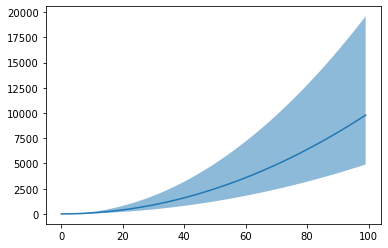

In [16]:
# Q3.2

# TODO: Plot the learning curve.
#       Below is a snippet for generate a curve with upper and lower bounds.
#       From your training loop above, save the episode rewards.
#       Rerun the training code a few times to get min and max.


import matplotlib.pyplot as plt

x = np.arange(100)
y = x ** 2
plt.plot(y)

lower_bound = 0.5*y
upper_bound = 2.0*y
plt.fill_between(x, lower_bound, upper_bound, alpha=0.5)

In [17]:
reward_matrix = np.zeros((10,8000))

for rep in range(10):
    # Q-table initialized to zeros.  first 4 dims are state, last dim is for action (0,1) for left,right.
    Q = np.zeros([num_bins]*len(obs)+[env.action_space.n])

    #import ipdb; ipdb.set_trace()
    for i in range(8000):
        obs = env.reset()
        s = obs2bin(obs)
        
        episode_reward =0
        while True:
            if np.random.rand() > eps:
                action = np.argmax(Q[s])
            else:
                action = env.action_space.sample()

            obs, reward, done, info=env.step(action)
            #if average_batch_reward>=:
            #    env.render()
            episode_reward+=reward

            s_prime = obs2bin(obs)
            Q[s][action] = Q[s][action]+alpha*(reward+gamma*np.max(Q[s_prime])-Q[s][action])
            s=s_prime
            if done:
                break
        reward_matrix[rep,i] =episode_reward

<ipython-input-12-30fe5443d2ac>:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bin_index = np.zeros(4,dtype=np.int)


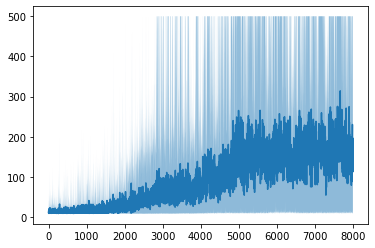

In [18]:
x = np.arange(8000)
y = np.average(reward_matrix, axis=0)
plt.plot(y)

lower_bound = np.amin(reward_matrix,axis=0)
upper_bound = np.amax(reward_matrix,axis=0)
plt.fill_between(x, lower_bound, upper_bound, alpha=0.5)

## 4. Experiments [20 pts]

Given a working algorithm, you will run a few experiments.  Either make a copy of your code above to modify, or make the modifications in a way that they can be commented out or switched between (with boolean flag if statements).

**4.2. [10pts] $\epsilon$-greedy.**  How sensitive are the results to the value of $\epsilon$?   First, write down your prediction of what would happen if $\epsilon$ is set to various values, including for example [0, 0.05, 0.25, 0.5].

The result is sensitive to $\epsilon$. When $\epsilon$ is large, then the optimal policy would not be executed all the time, and the average reward would be lower. When $\epsilon$ is small, then it could apporach optimal policy. If $\epsilon$ is 0, then the algorithm might not explore enough before finding the glocal optimal policy and stuck at local optimal policy. 

Now run the experiment and observe the impact on the algorithm.  Report the results below.

The code and graph are shown below. When $\epsilon$ is 0, then the algorithm stuck at a local extremum. With the increase of $\epsilon$, the algorithm would has a faster learning rate. However, while $\epsilon$ is too large, such as 0.5, then it is difficult to reach a optimal reward on average since the optimal policy is not applied all the time. 

<ipython-input-12-30fe5443d2ac>:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bin_index = np.zeros(4,dtype=np.int)


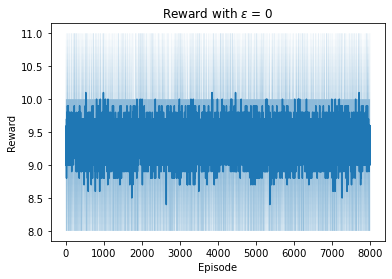

<ipython-input-12-30fe5443d2ac>:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bin_index = np.zeros(4,dtype=np.int)


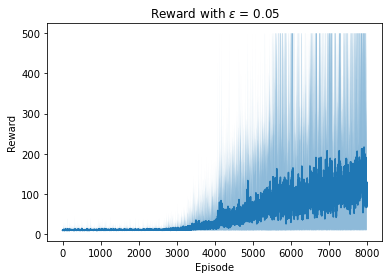

<ipython-input-12-30fe5443d2ac>:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bin_index = np.zeros(4,dtype=np.int)


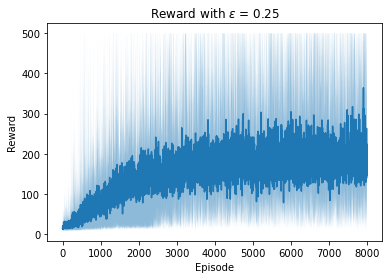

<ipython-input-12-30fe5443d2ac>:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bin_index = np.zeros(4,dtype=np.int)


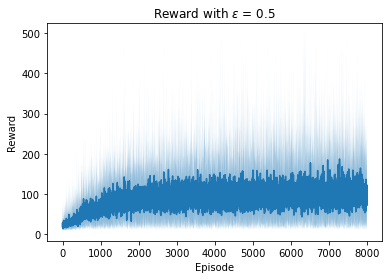

In [29]:
epses = [0,0.05,0.25,0.5]
for num in range(4):
    eps = epses[num]
    # Q-learning
    reward_matrix = np.zeros((10,8000))

    for rep in range(10):
        # Q-table initialized to zeros.  first 4 dims are state, last dim is for action (0,1) for left,right.
        Q = np.zeros([num_bins]*len(obs)+[env.action_space.n])

        #import ipdb; ipdb.set_trace()
        for i in range(8000):
            obs = env.reset()
            s = obs2bin(obs)
            
            episode_reward =0
            while True:
                if np.random.rand() > eps:
                    action = np.argmax(Q[s])
                else:
                    action = env.action_space.sample()

                obs, reward, done, info=env.step(action)
                #if average_batch_reward>=:
                #    env.render()
                episode_reward+=reward

                s_prime = obs2bin(obs)
                Q[s][action] = Q[s][action]+alpha*(reward+gamma*np.max(Q[s_prime])-Q[s][action])
                s=s_prime
                if done:
                    break
            reward_matrix[rep,i] =episode_reward
    # print result
    x = np.arange(8000)
    y = np.average(reward_matrix, axis=0)
    plt.plot(y)
    plt.title('Reward with $\epsilon$ = {}'.format(eps))
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    lower_bound = np.amin(reward_matrix,axis=0)
    upper_bound = np.amax(reward_matrix,axis=0)
    plt.fill_between(x, lower_bound, upper_bound, alpha=0.5)
    plt.show()

eps =0.05

**4.3. [10pts] Design your own experiment.** Design a modification that you think would either increase or reduce performance.  A simple example (which you can use) is initializing the Q-table differently, and thinking about how this might alter performance. Write down your idea, what you think might happen, and why.

Initilize all except terminal state arbitrarily instead of all 0. This might increase learning rate since there is initial tendency of favoring a policy at different state. Similar effect might be observed if the equal breaking implementation is random when Q-table is inialized to 0.

Run the experiment and report the results.

With randomized initialization, the learning rate is faster at the beginning

<ipython-input-12-30fe5443d2ac>:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bin_index = np.zeros(4,dtype=np.int)


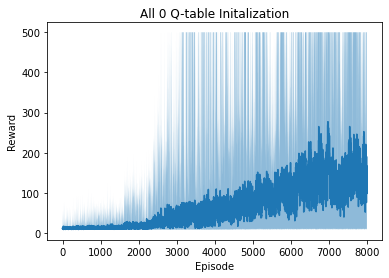

<ipython-input-12-30fe5443d2ac>:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bin_index = np.zeros(4,dtype=np.int)


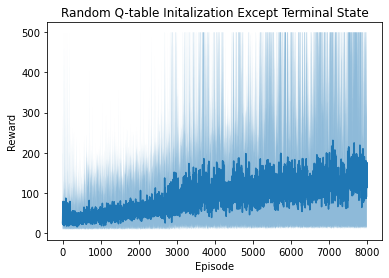

In [46]:
for num in range(2):
    # Q-learning
    reward_matrix = np.zeros((10,8000))

    for rep in range(10):
        # Q-table initialized to zeros.  first 4 dims are state, last dim is for action (0,1) for left,right.
        Q = np.zeros([num_bins]*len(obs)+[env.action_space.n])
        if num ==1:
            #add randomness to the inital Q-table
            Q = np.random.random_sample([num_bins]*len(obs)+[env.action_space.n])*20
            Q[:,:,0,:,:] = 0
            Q[:,:,9,:,:] = 0
        #import ipdb; ipdb.set_trace()
        for i in range(8000):
            obs = env.reset()
            s = obs2bin(obs)
            
            episode_reward =0
            while True:
                if np.random.rand() > eps:
                    action = np.argmax(Q[s])
                else:
                    action = env.action_space.sample()

                obs, reward, done, info=env.step(action)
                #if average_batch_reward>=:
                #    env.render()
                episode_reward+=reward

                s_prime = obs2bin(obs)
                Q[s][action] = Q[s][action]+alpha*(reward+gamma*np.max(Q[s_prime])-Q[s][action])
                s=s_prime
                if done:
                    break
            reward_matrix[rep,i] =episode_reward
    # print result
    x = np.arange(8000)
    y = np.average(reward_matrix, axis=0)
    plt.plot(y)
    if num==0:
        plt.title('All 0 Q-table Initalization')
    else:
        plt.title('Random Q-table Initalization Except Terminal State')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    lower_bound = np.amin(reward_matrix,axis=0)
    upper_bound = np.amax(reward_matrix,axis=0)
    plt.fill_between(x, lower_bound, upper_bound, alpha=0.5)
    plt.show()


---

## A. Extensions (optional)

- does the learning rate make a difference?
- visualize the Q-table to see which values are being updated and not
- design a better binning strategy that uses fewer bins for a better-performing policy
- extend this approach to work on different environments (e.g., LunarLander-v2)
- extend this approach to work on environments with continuous actions, by using a fixed set of discrete samples of the action space.  e.g., for Pendulum-v0
- implement a simple deep learning version of this.  we will see next homework that DQN uses some tricks to make the neural network training more stable.  Experiment directly with simply replacing the Q-table with a Q-Network and train the Q-Network using gradient descent with `loss = (targets - Q(s,a))**2`, where `targets = stop_grad(R + gamma * maxa(Q(s,a))`).